# **Age Group Classification using Multiple Touchscreen Gestures**

### Child Safety Project

Tom Birmingham & Dr. Hossain, Southern CT State University, Computer Science Department, New Haven, CT

![University Banner](<https://clubrunner.blob.core.windows.net/00000400324/EventImages/951e9035-3850-4f27-99d4-5a5d4bd17430-southern-connecticut-state-university(1).jpg>)

photo: [connecticut.csteachers.org](https://connecticut.csteachers.org/events/chapter-meeting-november-2019-southern-connecticut-state-university)


# About

This notebook represents the thesis work of graduate student Thomas Birmingham under the advisement of Dr. Hossain, Southern Connecticut State University (SCSU) Computer Science Department.

## Purpose

The purpose of the project is to further the state-of-the-art in age group classification using multiple touchscreen gestures and parallel fusion. Previous methods for classifying users (as child, teen, or adult) have been performed by other students in the project with Tap, Zoom, and Swipe gestures using machine learning. In order to further the state-of-the-art, this project will combine gestures using three types of parallel fusion to determine the most effective method for age group classification using multiple touchscreen gestures.

## Methodology

In order to determine the most effective method of parallel fusion for age classification, we must first obtain the same or better results of classification using features of each gesture Swipe, Zoom, and Tap. After classificiton of each gesture is completed, classification with parallel fusion will be performed at the feature level, score level, and decision level. The performance of each level of fusion will be assessed to determine the most effective method for age group classification.


# Prerequisites

This notebook was created on Apple M3 Max with 36 GB of memory. Not everyone has access to these computerers so this notebook can be made to run on Google Colab as well, where students can access shared compute resources with large amounts of RAM. This project has also been reviewed for memory optimization to reduce the amount of memory required to run these notebooks. For example, after loading the Child Safety Dataset, a Python object for each gesture is created as a Pandas Dataframes and exported to the /Checkpoints directory as a Python "pickle" file. Working from /Checkpoints allows users to resume their work without the time or space complexity of working with the raw dataset. You can check how much memory is available on your current runtime by running the following code block:

In [1]:
# check available memory
from psutil import virtual_memory

def print_available_memory():
    ram_gb = virtual_memory().total / 1024**3
    print('Your runtime has {:.1f} GB of available RAM\n'.format(ram_gb))
    if ram_gb < 20:
        print('This is not considered a high-RAM runtime')
    else:
        print('This is considered a high-RAM runtime')

print_available_memory()

Your runtime has 36.0 GB of available RAM

This is considered a high-RAM runtime


**Note:** Any variable **not** contained within a fuction is treated as a global variable. In the above code block, notice the variable `ram_gb` is contained within the function `print_available_memory()`. Variables that are contained within a function do not persist after the function has been called. Variables outside of functions are treated as global variables, will persist, and use available memory. While you work with this notebook, try not to use variables outside of function definitions unless they are needed. You can check variables in memory and their size in bytes using the following code block: 

In [2]:
# Standard library imports
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
initial_vars = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith(
    '_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

# Initialize total
total = 0

# Print header
print(f"{'variable':<15}{'size (bytes)':<15}")
print(f"{'--------':<15}{'------------':<15}")

# Print each variable and its size
for (var, size) in initial_vars:
    total += size
    if size > 160 and var not in ["initial_vars", "total"]:
        print(f"{var:<15}{size:<15}")

# Print total in KB or MB
if total < 1024 * 1024:
    print(f"\n{'TOTAL:':<15}{total/1024:.1f} KB")
else:
    print(f"\n{'TOTAL:':<15}{total/1024/1024:.1f} MB")

# Delete temporary variables
del ipython_vars, initial_vars, var, size, total

variable       size (bytes)   
--------       ------------   

TOTAL:         0.5 KB


Run this cell at any time to show what variables are used in memory and the total amount of memory used by these . Unused variables can be removed with the `del` keyword followed by the variable. Remove them after the cell where they are no longer used!

## Imports and Helper Functions
run Python Standard Library imports, Third-Party imports, and load helper functions into memory

In [41]:
# Standard library imports
import inspect
import json
import math
import os
import pickle
import sys
from glob import glob

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def load_dataframe(df_name):
    filepath = os.path.join("Checkpoints", f"{df_name}.pkl")
    if os.path.exists(filepath):
        with open(filepath, 'rb') as input:
            df = pd.read_pickle(input)
            print(f"Loaded {df_name} from {filepath}")
            return df
    else:
        print(f"File {filepath} does not exist.")
        return None


def save_dataframe(df):
    # Create the Checkpoints directory if it doesn't exist
    checkpoints_dir = 'Checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    # Get the variable name of the DataFrame dynamically
    frame = inspect.currentframe().f_back
    variable_name = None
    for name, value in frame.f_locals.items():
        if value is df:
            variable_name = name
            break

    if variable_name is None:
        raise ValueError("Could not determine the variable name of the DataFrame.")
    
    # Create the file path
    file_path = os.path.join(checkpoints_dir, f"{variable_name}.pkl")

    # Save the DataFrame as a pickle file
    with open(file_path, 'wb') as output:
        pickle.dump(df, output)
        print(f"DataFrame saved as {file_path}")
    

def get_dataset_files():
    if 'google.colab' in sys.modules:
        print("Using Google Colab hosted runtime")
        files = get_dataset_files_from_google_drive()
    else:
        print("Using local runtime")
        files = get_dataset_files_locally()
    return files


def get_dataset_files_from_google_drive():
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Create Symbolic Links to directories 'Child_Safety_Data' and 'Checkpoints'
    ! ln -s "/content/drive/MyDrive/Child Safety Project/Child_Safety_Data"
    ! ln -s "/content/drive/MyDrive/Child Safety Project/Checkpoints"

    # Get files in Child_Safety_Data and output total number of files
    files = glob(r'Child_Safety_Data/**/*.txt', recursive=True)
    print("Total Files:", len(files))
    return files


def get_dataset_files_locally():
    files = glob(r'../Dataset/Child_Safety_Data/**/*.txt', recursive=True)
    print("Total Files:", len(files))
    return files

# Data Collection
The Data Collection section loads the required data from the `Child_Safety_Data` dataset into Pandas DataFrames for further Feature Extraction, Classification, and Regression. The resulting DataFrames are:
* `user_df` containing demographics data about each study participant. Only uniquely identifyable study participants are retained.
* `session_df` containing session data for each user's session. Each session is a data collection event with multiple touchscreen gestures for one type of gesture (tap, zoom, or swipe).
* `tap_df` containing raw data from all tap events.
* `zoom_df` containing raw data from all zoom events (zoom-in and zoom-out).
* `swipe_df` containing raw data from all swipe events (swipe-up, swipe-down, swipe-left, swipe-right).

## Get Users
load `user_df` into memory

In [4]:
def get_user_df():

    # attempt to load dataframe from checkpoint
    user_df = load_dataframe("user_df")

    # if checkpoint does not exist, create and save dataframe
    if (user_df is None):
        user_df = build_user_df()
        save_dataframe(user_df)

    return user_df


def build_user_df():

    user_file_dfs = list() # a list of dataframes, one user for each file in the dataset, to be concatenated into a single dataframe, user_df

    for file in get_dataset_files():
        filename = file.split('/')[-1]
        if "mod0" in filename:
            with open(file) as file:
                # user data to extract from each file
                user_id = ''
                researcher = ''
                grade = ''
                gender = ''
                age = ''
                teacher = ''

                # researcher
                if filename[0] == '_':
                    researcher = 'Carl'
                elif filename[0] != '_':
                    researcher = 'Kate'

                # get data from file
                for line in file:

                    # collect key value pairs from file
                    if "=" in line:
                        key, value = line.strip().split("=")
                        
                        key = key.lower()
                        if key == "grade":
                            grade = value
                        elif key == "gender" or key == "student":
                            gender = value
                        elif key == "age" or key == "studentage":
                            age = value
                        elif key == "teacher":
                            teacher = value

                # User Unique Identifiers
                if researcher == 'Carl':
                    user_id = filename.split('_')[1]
                elif researcher == 'Kate':
                    user_id = teacher + grade + gender + age

                # Note: Kate had recorded data differently than Carl
                # where Carl collected [datetime, session number, machine name, grade,
                # gender, age, middle initial, birth month, and birth day],
                # Kate collected [datetime, session number, machine name, teacher,
                # grade, gender, and age].
                # Carl generated and assigned a unique identifier to each study participant,
                # but we do not have a unique identifier for each of Kate's participants.
                # We try to generate as unique an identifier as possible using a combination of
                # teacher, grade, gender, and age, but there are duplicate user ids and
                # therefore we cannot use all Kate's data. This is only an issue as we need
                # to combine multiple gestures for each user, where each user's gesture samples 
                # comes from a different session.

                # create user dataframe for each file and append it to a list
                user_data = {}
                user_data['user_id'] = user_id
                user_data['age'] = age
                user_data['grade'] = grade
                user_data['gender'] = gender
                user_data['researcher'] = researcher
                user_file_df = pd.DataFrame(user_data, index=[0])
                user_file_dfs.append(user_file_df)
    
    # concatenate dataframes of user data into a single dataframe
    user_df = pd.concat(user_file_dfs)

    # remove all user ids that are duplicates from kate
    # (cannot assign sessions from duplicate users to a unique user)
    is_duplicate_kate = (user_df['researcher'] == 'Kate') & user_df.duplicated(subset='user_id', keep=False)
    user_df = user_df[~is_duplicate_kate | (user_df['researcher'] != 'Kate')]

    # Keep first user_id from Carl
    user_df = user_df.drop_duplicates(subset='user_id', keep='first')

    # reset indexes
    user_df = user_df.reset_index(drop=True)

    # set data types
    user_df['age'] = user_df['age'].astype(int)
    user_df['grade'] = user_df['grade'].astype(int)

    # add age group
    user_df['age_group'] = user_df['age'].apply(get_age_group)

    return user_df


def get_age_group(age):
    if age < 13:
        return 'child'
    elif age < 18:
        return 'teen'
    else:
        return 'adult'


# return user_df as global variable
user_df = get_user_df()

File Checkpoints/user_df.pkl does not exist.
Using local runtime
Total Files: 6287
DataFrame saved as Checkpoints/user_df.pkl


In [5]:
user_df.head()

,user_id,age,grade,gender,researcher,age_group
0,14S0915,18,14,M,Carl,adult
1,14T1227,19,14,M,Carl,adult
2,NEVOLIS12M18,18,12,M,Kate,adult
3,ROY12M17,17,12,M,Kate,teen
4,REGAN12F17,17,12,F,Kate,teen


## Get Sessions
load `session_df` into memory

In [6]:
def get_session_df():

    # attempt to load dataframe from checkpoint
    session_df = load_dataframe("session_df")

    # if checkpoint does not exist, create and save dataframe
    if (session_df is None):
        session_df = build_session_df()
        save_dataframe(session_df)

    return session_df


def build_session_df():
    print("Building session_df from data")

    session_file_dfs = list() # a list of dataframes, one session for each file in the dataset, to be concatenated into a single dataframe, user_df

    for file in get_dataset_files():

        filename = file.split('/')[-1]

        if "mod0" in filename:

            with open(file) as file:

                # expected data in file
                session_id = ''
                user_id = ''
                researcher = ''
                datetime = ''
                device = ''
                device_type = ''
                session = ''
                grade = ''
                gender = ''
                age = ''
                teacher = ''

                # researcher
                if filename[0] == '_':
                    researcher = 'Carl'
                elif filename[0] != '_':
                    researcher = 'Kate'

                # get data from file
                for line in file:
                    if "=" in line:

                        # collect key value pairs from file
                        key, value = line.strip().split("=")
                        key = key.lower()
                        if key == "colldatetime":
                            datetime = value
                        elif key == "machname":
                            device = value
                        elif key == "session":
                            session = value
                        elif key == "grade":
                            grade = value
                        elif key == "gender" or key == "student":
                            gender = value
                        elif key == "age" or key == "studentage":
                            age = value
                        elif key == "teacher":
                            teacher = value

                session_id = device + "_" + session

                # User Unique Identifiers
                if researcher == 'Carl':
                    user_id = filename.split('_')[1]
                elif researcher == 'Kate':
                    user_id = teacher + grade + gender + age

                # Device Type
                if 'm' in device:
                    device_type = 'tablet'
                elif 'p' in device:
                    device_type = 'phone'

                # create session dataframe for each file and append it to a list
                session_data = {}
                session_data['session_id'] = session_id
                session_data['user_id'] = user_id
                session_data['datatime'] = datetime
                session_data['device'] = device
                session_data['session'] = session
                session_data['device_type'] = device_type
                session_file_df = pd.DataFrame(session_data, index=[0])
                session_file_dfs.append(session_file_df)

    # Create Session DataFrame
    session_df = pd.concat(session_file_dfs)

    # Drop sessions from session dataframe where there is not a unique user id
    print("Removing sessions where there is not a unique user id...")
    unique_user_ids = get_user_df()['user_id'].unique()
    mask = session_df['user_id'].isin(unique_user_ids)
    session_df = session_df[mask]

    # reset index
    session_df = session_df.reset_index(drop=True)

    return session_df


# return session_df as global variable
session_df = get_session_df()

File Checkpoints/session_df.pkl does not exist.
Building session_df from data
Using local runtime
Total Files: 6287
Removing sessions where there is not a unique user id...
Loaded user_df from Checkpoints/user_df.pkl
DataFrame saved as Checkpoints/session_df.pkl


In [7]:
session_df.head()

,session_id,user_id,datatime,device,session,device_type
0,p2_29,14S0915,Wed 2019-9-04 07:28,p2,29,phone
1,p7_38,14T1227,Wed 2019-8-28 07:28,p7,38,phone
2,p3_12,NEVOLIS12M18,Fri 2019-2-01 10:48,p3,12,phone
3,p7_8,ROY12M17,Thu 2019-1-31 11:59,p7,8,phone
4,p1_17,REGAN12F17,Wed 2019-2-06 11:12,p1,17,phone


## Get Tap Data
load `tap_df` into memory

In [8]:
def get_tap_df():

    # attempt to load dataframe from checkpoint
    tap_df = load_dataframe("tap_df")

    # if checkpoint does not exist, create and save dataframe
    if (tap_df is None):
        tap_df = build_tap_df()
        save_dataframe(tap_df)

    return tap_df


def build_tap_df():
    print("Building tap_df...")
    
    # Initialize Data Structures
    file_df = pd.DataFrame()
    file_dfs = list()
    tap_df = pd.DataFrame()
    session_df = get_session_df()

    for file in get_dataset_files():

        # get filename
        filename = file.split('/')[-1]

        # get session id
        session_id = filename.split('_')[-4] + '_' + filename.split('_')[-3]

        # Process mod5 (tap) files if session captured
        if ('mod5' in filename) and (session_id in session_df['session_id'].unique()):

            with open(file) as file:

                fileDictionary = {}

                for line in file:
                    line = line.strip()

                    if line:
                        # Add key and value list to dictionary
                        if ":" in line:
                            # split the line into key and values
                            key, values = line.split(': ')
                            # split values into list
                            values = values.split(' ')
                            # add the key-value pair to the dictionary
                            fileDictionary[key] = values

                # Build file dataframe from dictionary
                file_df = pd.DataFrame.from_dict(fileDictionary, orient='index').transpose()

                # Release memory of fileDictionary TODO: Why do we need to do this? Is it necessary?
                # fileDictionary = {}

                # Insert user_id and session_id from session dataframe
                user_id = session_df.loc[session_df['session_id'] == session_id, 'user_id'].iloc[0]
                file_df.insert(0, 'session_id', session_id)
                file_df.insert(1, 'user_id', user_id)

                # Append to list of file dataframes
                file_dfs.append(file_df)

    # Concatenate dataframes from files into single dataframe
    tap_df = pd.concat(file_dfs)

    # Clean dataframe
    tap_df = clean_tap_df(tap_df)

    return tap_df


def clean_tap_df(tap_df):
    # Rename Columns
    tap_df = tap_df.rename(columns={
        'Time': 'mille',
        'Tapped': 'tapped',
        'Action': 'action',
        'X': 'x',
        'Y': 'y',
        'Size': 'size',
        'Pressure': 'pressure'
    })

    # Replace Actions
    tap_df['action'] = tap_df['action'].replace(to_replace={
        '0': 'DOWN-1ST',
        '2': 'MOVE',
        '1': 'UP-LAST'
    })

    # Generate unique Event IDs for all events starting with 'DOWN-1ST'
    tap_df.insert(2, 'event_no', (tap_df['action'] == 'DOWN-1ST').cumsum())

    # Specify Data Types
    tap_df = tap_df.astype({
        'mille': 'int64',
        'tapped': 'int32',
        'x': 'float64',
        'y': 'float64',
        'size': 'float64',
        'pressure': 'float64'
    })

    return tap_df


# return tap_df as global variable
tap_df = get_tap_df()

File Checkpoints/tap_df.pkl does not exist.
Building tap_df...
Loaded session_df from Checkpoints/session_df.pkl
Using local runtime
Total Files: 6287
DataFrame saved as Checkpoints/tap_df.pkl


In [9]:
tap_df.head()

,session_id,user_id,event_no,mille,tapped,action,x,y,size,pressure
0,p7_38,14T1227,1,2508201,1,DOWN-1ST,186.7356,87.57617,0.224609,1.0500
1,p7_38,14T1227,1,2508228,1,MOVE,186.7356,87.57617,0.223633,1.0625
2,p7_38,14T1227,1,2508245,1,MOVE,186.7356,87.57617,0.223633,1.0500
3,p7_38,14T1227,1,2508262,1,MOVE,186.7356,87.57617,0.224609,1.0000
4,p7_38,14T1227,1,2508278,1,UP-LAST,186.7356,87.57617,0.224609,1.0000


## Get Zoom Data
load `zoom_df` into memory

In [10]:
def get_zoom_df():

    # attempt to load dataframe from checkpoint
    zoom_df = load_dataframe("zoom_df")

    # if checkpoint does not exist, create and save dataframe
    if (zoom_df is None):
        zoom_df = build_zoom_df()
        save_dataframe(zoom_df)

    return zoom_df


def build_zoom_df():
    print("Building zoom_df...")

    # Initialize Data Structures
    file_df = pd.DataFrame()
    file_dfs = list()
    zoom_df = pd.DataFrame()
    session_df = get_session_df()

    # Select Event Source:
    #   'tc' for current event or
    #   'th' for history queue
    # both sources of data are available in the dataset
    source = 'tc'

    for file in get_dataset_files():

        # get filename
        filename = file.split('/')[-1]

        # get session id
        session_id = filename.split('_')[-4] + '_' + filename.split('_')[-3]

       # Process Zoom Gestures (mod6) if session in session dataframe
        if ('mod6' in filename) and (session_id in session_df['session_id'].unique()):

            # open file and read all json lines into event list
            event_list = []
            with open(file) as file:

                # select lines from selected source
                for line in file:
                    line = json.loads(line)
                    if "type" in line and line["type"] == source.lower():

                        line["mille"] = line["mille"]
                        line["pcnt"] = line["pcnt"]
                        line["pid"] = line["pid"]
                        line["pidx"] = line["pidx"]
                        line["x"] = line["x"]
                        line["y"] = line["y"]
                        line["size"] = line["size"]
                        line["press"] = line["press"]
                        line["vx"] = line["vx"]
                        line["vy"] = line["vy"]

                        # Append json to event list
                        event_list.append(line)

            # Build file dataframe from event list
            file_df = pd.DataFrame(event_list)

            # Drop unused columns from DataFrame
            if 'src' in file_df:
                file_df = file_df.drop(columns=['src'])

            # Insert user_id and session_id from session dataframe
            user_id = session_df.loc[session_df['session_id']
                                     == session_id, 'user_id'].iloc[0]
            file_df.insert(0, 'session_id', session_id)
            file_df.insert(1, 'user_id', user_id)

            # Append to list of all file dataframes
            file_dfs.append(file_df)

    # Concatenate all file dataframes into single dataframe
    zoom_df = pd.concat(file_dfs)

    # Rename columns
    zoom_df = zoom_df.rename(columns={
        "act": "action",
        "press": "pressure"
    })

    # Generate unique Event IDs for all events starting with 'DOWN-1ST'
    zoom_df.insert(0, 'event_no', (zoom_df['action'] == 'DOWN-1ST').cumsum())

    # Set data types
    zoom_df['mille'] = zoom_df['mille'].astype(int)
    zoom_df['pcnt'] = zoom_df['pcnt'].astype(int)
    zoom_df['pid'] = zoom_df['pid'].astype(int)
    zoom_df['pidx'] = zoom_df['pidx'].astype(int)
    zoom_df['x'] = zoom_df['x'].astype(float)
    zoom_df['y'] = zoom_df['y'].astype(float)
    zoom_df['size'] = zoom_df['size'].astype(float)
    zoom_df['pressure'] = zoom_df['pressure'].astype(float)
    zoom_df['vx'] = zoom_df['vx'].astype(float)
    zoom_df['vy'] = zoom_df['vy'].astype(float)

    # Set all velocities to positive
    zoom_df['vx'] = zoom_df['vx'].abs()
    zoom_df['vy'] = zoom_df['vy'].abs()

    # Replace null (NaN) values in 'vx' and 'vy' with 0
    zoom_df['vx'] = zoom_df['vx'].fillna(0)
    zoom_df['vy'] = zoom_df['vy'].fillna(0)

    # Replace infinite values in 'vx' or 'vy' with 0
    zoom_df['vx'] = zoom_df['vx'].replace([np.inf, -np.inf], 0)
    zoom_df['vy'] = zoom_df['vy'].replace([np.inf, -np.inf], 0)

    return zoom_df


# return zoom_df as global variable
zoom_df = get_zoom_df()

File Checkpoints/zoom_df.pkl does not exist.
Building zoom_df...
Loaded session_df from Checkpoints/session_df.pkl
Using local runtime
Total Files: 6287
DataFrame saved as Checkpoints/zoom_df.pkl


In [11]:
zoom_df.head()

,event_no,session_id,user_id,mille,type,test,hrow,pcnt,pid,pidx,action,x,y,size,pressure,vx,vy
0,1,p7_38,14T1227,2576890,tc,mod6,C,1,0,0,DOWN-1ST,846.37,1406.46,0.1958,0.7250,0.0003,0.0005
1,1,p7_38,14T1227,2576897,tc,mod6,C,1,0,0,MOVE,846.37,1406.46,0.1978,0.7375,0.0000,0.0000
2,1,p7_38,14T1227,2576914,tc,mod6,C,1,0,0,MOVE,846.37,1406.46,0.2021,0.7625,0.0000,0.0000
3,1,p7_38,14T1227,2576930,tc,mod6,C,1,0,0,MOVE,846.37,1406.46,0.2056,0.7875,0.0000,0.0000
4,1,p7_38,14T1227,2576947,tc,mod6,C,1,0,0,MOVE,846.37,1406.46,0.2192,0.8250,0.0000,0.0000


## Get Swipe Data
load `swipe_df` into memory

In [12]:
def get_swipe_df():

    # attempt to load dataframe from checkpoint
    swipe_df = load_dataframe("swipe_df")

    # if checkpoint does not exist, create and save dataframe
    if (swipe_df is None):
        swipe_df = build_swipe_df()
        save_dataframe(swipe_df)

    return swipe_df


def build_swipe_df():
    print("Building swipe_df...")

    # Initialize Data Structures
    file_df = pd.DataFrame()
    file_dfs = list()
    swipe_df = pd.DataFrame()
    session_df = get_session_df()

    # Select Event Source:
    #   'tc' for current event or
    #   'th' for history queue
    # both sources of data are available in the dataset
    source = 'tc'

    for file in get_dataset_files():

        # get filename
        filename = file.split('/')[-1]

        # get session id
        session_id = filename.split('_')[-4] + '_' + filename.split('_')[-3]

        # Process Swipe Gestures (mod2, mod3) if session in session dataframe
        if ('mod2' in filename or 'mod3' in filename) and \
                session_id in session_df['session_id'].unique():

            # open file and read all json lines into event list
            event_list = []
            with open(file) as file:

                # select lines from selected source
                for line in file:
                    line = json.loads(line)
                    if "type" in line and line["type"] == source.lower():

                        line["mille"] = line["mille"]
                        line["pcnt"] = line["pcnt"]
                        line["pid"] = line["pid"]
                        line["pidx"] = line["pidx"]
                        line["x"] = line["x"]
                        line["y"] = line["y"]
                        line["size"] = line["size"]
                        line["press"] = line["press"]
                        line["vx"] = line["vx"]
                        line["vy"] = line["vy"]

                        # Horizontal and Vertical Labels
                        if 'mod2' in line['test']:
                            line['test'] = 'horizontal'
                        elif 'mod3' in line['test']:
                            line['test'] = 'vertical'

                        # Append json to event list
                        event_list.append(line)

            # Build file dataframe from event list
            file_df = pd.DataFrame(event_list)

            # Drop unused columns from DataFrame
            if 'src' in file_df:
                file_df = file_df.drop(columns=['src'])

            # Insert user_id and session_id from session dataframe
            user_id = session_df.loc[session_df['session_id']
                                     == session_id, 'user_id'].iloc[0]
            file_df.insert(0, 'session_id', session_id)
            file_df.insert(1, 'user_id', user_id)

            # Append to list of all file dataframes
            file_dfs.append(file_df)

    # Concatenate all file dataframes into single swipe dataframe
    swipe_df = pd.concat(file_dfs)

    # Rename columns
    swipe_df = swipe_df.rename(columns={
        "test": "orientation",
        "act": "action",
        "press": "pressure"
    })

    # Generate unique Event IDs for all events starting with 'DOWN-1ST'
    swipe_df.insert(0, 'event_no', (swipe_df['action'] == 'DOWN-1ST').cumsum())

    # Set data types
    swipe_df['mille'] = swipe_df['mille'].astype(int)
    swipe_df['pcnt'] = swipe_df['pcnt'].astype(int)
    swipe_df['pid'] = swipe_df['pid'].astype(int)
    swipe_df['pidx'] = swipe_df['pidx'].astype(int)
    swipe_df['x'] = swipe_df['x'].astype(float)
    swipe_df['y'] = swipe_df['y'].astype(float)
    swipe_df['size'] = swipe_df['size'].astype(float)
    swipe_df['pressure'] = swipe_df['pressure'].astype(float)
    swipe_df['vx'] = swipe_df['vx'].astype(float)
    swipe_df['vy'] = swipe_df['vy'].astype(float)

    # Set all velocities to positive
    swipe_df['vx'] = swipe_df['vx'].abs()
    swipe_df['vy'] = swipe_df['vy'].abs()

    # Replace null (NaN) values in 'vx' and 'vy' with 0
    swipe_df['vx'] = swipe_df['vx'].fillna(0)
    swipe_df['vy'] = swipe_df['vy'].fillna(0)

    # Replace infinite values in 'vx' or 'vy' with 0
    swipe_df['vx'] = swipe_df['vx'].replace([np.inf, -np.inf], 0)
    swipe_df['vy'] = swipe_df['vy'].replace([np.inf, -np.inf], 0)

    return swipe_df


# return swipe_df as global variable
swipe_df = get_swipe_df()

File Checkpoints/swipe_df.pkl does not exist.
Building swipe_df...
Loaded session_df from Checkpoints/session_df.pkl
Using local runtime
Total Files: 6287
DataFrame saved as Checkpoints/swipe_df.pkl


In [13]:
swipe_df.head()

,event_no,session_id,user_id,mille,type,orientation,hrow,pcnt,pid,pidx,action,x,y,size,pressure,vx,vy
0,1,p7_38,14T1227,2543160,tc,vertical,C,1,0,0,DOWN-1ST,976.28,1605.39,0.1655,0.6000,0.0004,0.0006
1,1,p7_38,14T1227,2543186,tc,vertical,C,1,0,0,MOVE,976.28,1605.39,0.1665,0.6250,0.0000,0.0000
2,1,p7_38,14T1227,2543202,tc,vertical,C,1,0,0,MOVE,976.28,1607.83,0.1675,0.6375,0.0000,0.1524
3,1,p7_38,14T1227,2543219,tc,vertical,C,1,0,0,MOVE,978.13,1630.87,0.1694,0.6500,0.0501,0.8522
4,1,p7_38,14T1227,2543236,tc,vertical,C,1,0,0,MOVE,983.05,1725.11,0.1675,0.6375,0.1041,3.2793


# Feature Extraction
The Feature Extraction section defines and extracts features for all Tap, Zoom, and Swipe events and creates a DataFrame of features for each event of that type. The resulting DataFrames are:
* `tap_features_df` containing a set of features for each tap gesture by event_no.
* `swipe_features_df` containing a set of features for each swipe gesture by event_no.
* `zoom_features_df` containing a set of features for each zoom gesture by event_no.

## Get Tap Features
load `tap_features_df` into memory

In [14]:
class TapEvent:

    def __init__(self, df):
        self.df = df.reset_index()

    def is_valid(self):
        if self.df['action'].iloc[0] == 'DOWN-1ST' and self.df['action'].iloc[-1] == 'UP-LAST':
            return True
        return False

    def get_feature_dataframe(self):
        # filter invalid events
        if not self.is_valid():
            print('Event No {} is invalid.'.format(
                self.df['event_no'].iloc[0]))
            return None

        # return dataframe constructed from dictionary of feature key-value pairs
        return pd.DataFrame(self.get_all_feature_values(), index=[0])

    def get_all_feature_values(self):
        feature_values = {}

        # Parent DataFrame
        feature_values['user_id'] = TapEvent.get_user_id(self.df)
        feature_values['session_id'] = TapEvent.get_session_id(self.df)
        feature_values['device_type'] = TapEvent.get_device_type(self.df)
        feature_values['event_no'] = TapEvent.get_event_no(self.df)
        feature_values['tapped'] = TapEvent.get_tapped(self.df)
        feature_values['age'] = TapEvent.get_age(self.df)
        feature_values['age_group'] = TapEvent.get_age_group(self.df)

        # Size Features
        feature_values['start_size'] = TapEvent.get_start_size(self.df)
        feature_values['end_size'] = TapEvent.get_end_size(self.df)
        feature_values['max_size'] = TapEvent.get_max_size(self.df)
        feature_values['min_size'] = TapEvent.get_min_size(self.df)
        feature_values['avg_size'] = TapEvent.get_avg_size(self.df)
        feature_values['range_in_size'] = TapEvent.get_range_in_size(self.df)

        # Pressure Features
        feature_values['start_pressure'] = TapEvent.get_start_pressure(self.df)
        feature_values['end_pressure'] = TapEvent.get_end_pressure(self.df)
        feature_values['max_pressure'] = TapEvent.get_max_pressure(self.df)
        feature_values['min_pressure'] = TapEvent.get_min_pressure(self.df)
        feature_values['avg_pressure'] = TapEvent.get_avg_pressure(self.df)
        feature_values['range_in_pressure'] = TapEvent.get_range_in_pressure(
            self.df)

        # Distance Features
        feature_values['total_distance'] = TapEvent.get_total_distance(self.df)
        feature_values['distance_to_max_pressure'] = TapEvent.get_distance_start_max_pressure(
            self.df)
        feature_values['distance_to_min_pressure'] = TapEvent.get_distance_start_min_pressure(
            self.df)

        # Time Features
        feature_values['hold_time'] = TapEvent.get_hold_time(self.df)
        feature_values['time_to_max_pressure'] = TapEvent.get_time_to_max_pressure(
            self.df)
        feature_values['time_to_min_pressure'] = TapEvent.get_time_to_min_pressure(
            self.df)

        # Product Features
        feature_values['product_of_max_size_and_max_pressure'] = TapEvent.get_product_max_size_max_pressure(
            self.df)
        feature_values['product_of_max_size_and_hold_time'] = TapEvent.get_product_max_size_hold_time(
            self.df)
        feature_values['product_of_min_size_and_hold_time'] = TapEvent.get_product_min_size_hold_time(
            self.df)
        feature_values['product_of_avg_size_and_hold_time'] = TapEvent.get_product_avg_size_hold_time(
            self.df)

        # Slope Features
        feature_values['slope_start_to_end'] = TapEvent.get_slope_start_end(
            self.df)
        feature_values['slope_start_to_median'] = TapEvent.get_slope_start_median(
            self.df)
        feature_values['slope_median_to_end'] = TapEvent.get_slope_median_end(
            self.df)

        return feature_values

    # Helper Methods -------------------------------------------------------------

    # Data from parent DataFrame

    def get_user_id(df):
        return df['user_id'].iloc[0]

    def get_session_id(df):
        return df['session_id'].iloc[0]

    def get_device_type(df):
        return session_df.loc[session_df['session_id'] == df['session_id'].iloc[0], 'device_type'].values[0]

    def get_event_no(df):
        return df['event_no'].iloc[0]

    def get_tapped(df):
        return df['tapped'].iloc[0]

    def get_age(df):
        return user_df.loc[user_df['user_id'] == df['user_id'].iloc[0], 'age'].values[0]

    def get_age_group(df):
        return user_df.loc[user_df['user_id'] == df['user_id'].iloc[0], 'age_group'].values[0]

    # Time Features

    def get_time_to_max_pressure(df):
        max_pressure_index = df['pressure'].idxmax()
        time_to_max_pressure = df['mille'].iloc[max_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_max_pressure

    def get_time_to_min_pressure(df):
        min_pressure_index = df['pressure'].idxmin()
        time_to_min_pressure = df['mille'].iloc[min_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_min_pressure

    def get_hold_time(df):
        hold_time = df['mille'].iloc[-1] - df['mille'].iloc[0]
        return hold_time

    # Size Features

    def get_start_size(df):
        return df['size'].iloc[0]

    def get_end_size(df):
        return df['size'].iloc[-1]

    def get_max_size(df):
        return df['size'].max()

    def get_min_size(df):
        return df['size'].min()

    def get_avg_size(df):
        return df['size'].mean()

    def get_range_in_size(df):
        return abs(TapEvent.get_max_size(df) - TapEvent.get_min_size(df))

    # Pressure Features

    def get_start_pressure(df):
        return df['pressure'].iloc[0]

    def get_end_pressure(df):
        return df['pressure'].iloc[-1]

    def get_max_pressure(df):
        return df['pressure'].max()

    def get_min_pressure(df):
        return df['pressure'].min()

    def get_avg_pressure(df):
        return df['pressure'].mean()

    def get_range_in_pressure(df):
        return abs(TapEvent.get_max_pressure(df) - TapEvent.get_min_pressure(df))

    # Velocity Features

    def get_start_vx(df):
        return df['vx'].iloc[0]

    def get_end_vx(df):
        return df['vx'].iloc[-1]

    def get_max_vx(df):
        return df['vx'].max()

    def get_min_vx(df):
        return df['vx'].min()

    def get_avg_vx(df):
        return df['vx'].mean()

    def get_start_vy(df):
        return df['vy'].iloc[0]

    def get_end_vy(df):
        return df['vy'].iloc[-1]

    def get_max_vy(df):
        return df['vy'].max()

    def get_min_vy(df):
        return df['vy'].min()

    def get_avg_vy(df):
        return df['vy'].mean()

    def get_range_in_vy(df):
        max_vy = TapEvent.get_max_vy(df)
        min_vy = TapEvent.get_min_vy(df)
        if max_vy == float('Inf') or min_vy == float('Inf'):
            return float('Inf')
        elif max_vy == float('NaN') or min_vy == float('NaN'):
            return float('NaN')
        else:
            return abs(max_vy - min_vy)

    # Distance Features

    def get_total_distance(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_distance_start_max_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        max_pressure_index = df['pressure'].idxmax()
        max_pressure_x = df['x'].iloc[max_pressure_index]
        max_pressure_y = df['y'].iloc[max_pressure_index]
        distance = math.sqrt((max_pressure_x - start_x) **
                             2 + (max_pressure_y - start_y)**2)
        return distance

    def get_distance_start_min_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        min_pressure_index = df['pressure'].idxmin()
        min_pressure_x = df['x'].iloc[min_pressure_index]
        min_pressure_y = df['y'].iloc[min_pressure_index]
        distance = math.sqrt((min_pressure_x - start_x) **
                             2 + (min_pressure_y - start_y)**2)
        return distance

    # Product Features

    def get_product_max_size_max_pressure(df):
        return TapEvent.get_max_size(df) * TapEvent.get_max_pressure(df)

    def get_product_avg_size_hold_time(df):
        return TapEvent.get_avg_size(df) * TapEvent.get_hold_time(df)

    def get_product_max_size_hold_time(df):
        return TapEvent.get_max_size(df) * TapEvent.get_hold_time(df)

    def get_product_min_size_hold_time(df):
        return TapEvent.get_min_size(df) * TapEvent.get_hold_time(df)

    # Slope Features

    def get_slope_start_end(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = float('NaN')  # vertical slope is undefined
        return slope

    def get_slope_start_median(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        if x_median - x1 != 0:
            slope = (y_median - y1) / (x_median - x1)
        else:
            slope = float('NaN')  # vertical slope is undefined
        return slope

    def get_slope_median_end(df):
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        x_end = df['x'].iloc[-1]
        y_end = df['y'].iloc[-1]
        if x_end - x_median != 0:
            slope = (y_end - y_median) / (x_end - x_median)
        else:
            slope = float('NaN')  # vertical slope is undefined
        return slope

In [15]:
def get_tap_features_df():

    # attempt to load dataframe from checkpoint
    tap_features_df = load_dataframe("tap_features_df")

    # if checkpoint does not exist, create and save dataframe
    if (tap_features_df is None):
        tap_features_df = build_tap_features_df()
        save_dataframe(tap_features_df)

    return tap_features_df


def build_tap_features_df():

    print("Building tap_features_df...")

    # list of tap feature dfs, one for each event, to be concatenated at the end
    tap_feature_dfs = list()

    # Get tap_df
    tap_df = get_tap_df()

    # Get tap events
    events = tap_df['event_no'].unique()
    
    # For each event get features dataframe and append to list
    for event in events:
        tap_event_df = tap_df[tap_df['event_no'] == event]
        tap_event_df = TapEvent(tap_event_df).get_feature_dataframe()
        tap_feature_dfs.append(tap_event_df)

    # concatenate all tap features into a single dataframe
    tap_features_df = pd.concat(tap_feature_dfs)

    # Replace Not a Number (NaN) with zero
    tap_features_df = tap_features_df.fillna(0)

    # Replace infinite values with 0
    tap_features_df = tap_features_df.replace([np.inf, -np.inf], 0)

    # Reset Indexes
    tap_features_df = tap_features_df.reset_index()

    # Remove redundant Index column
    tap_features_df = tap_features_df.drop(columns=['index'])

    return tap_features_df

# return tap_features_df as global variable
tap_features_df = get_tap_features_df()

File Checkpoints/tap_features_df.pkl does not exist.
Building tap_features_df...
Loaded tap_df from Checkpoints/tap_df.pkl
Event No 21613 is invalid.
Event No 29097 is invalid.
DataFrame saved as Checkpoints/tap_features_df.pkl


In [16]:
tap_features_df.head()

,user_id,session_id,device_type,event_no,tapped,age,age_group,start_size,end_size,max_size,...,hold_time,time_to_max_pressure,time_to_min_pressure,product_of_max_size_and_max_pressure,product_of_max_size_and_hold_time,product_of_min_size_and_hold_time,product_of_avg_size_and_hold_time,slope_start_to_end,slope_start_to_median,slope_median_to_end
0,14T1227,p7_38,phone,1,1,19,adult,0.224609,0.224609,0.224609,...,77,27,61,0.238647,17.294922,17.219726,17.264844,0.000000,0.000000,0.000000
1,14T1227,p7_38,phone,2,2,19,adult,0.200195,0.202637,0.203613,...,57,36,0,0.155255,11.605957,11.411133,11.528027,-1.167037,0.000000,-5.182586
2,14T1227,p7_38,phone,3,3,19,adult,0.214844,0.214844,0.217285,...,134,87,0,0.206421,29.116211,28.789062,28.911743,0.400138,-0.268048,0.875670
3,14T1227,p7_38,phone,4,4,19,adult,0.178711,0.182129,0.182129,...,79,53,0,0.141150,14.388183,14.118164,14.264746,0.000000,0.000000,0.000000
4,14T1227,p7_38,phone,5,5,19,adult,0.208496,0.210938,0.210938,...,117,44,93,0.197754,24.679688,24.394044,24.565430,1.250450,0.000000,1.250450


## Get Zoom Features
load `zoom_features_df` into memory

In [17]:
class ZoomEvent:
    def __init__(self, df):
        self.df = df.reset_index()
        # event df of first finger
        self.f1_df = self.df[self.df['pid'] == self.df['pid'].iloc[0]]
        self.f1_df = self.f1_df.reset_index()
        # event df of second finger
        self.f2_df = self.df[self.df['pid'] != self.df['pid'].iloc[0]]
        self.f2_df = self.f2_df.reset_index()

    def get_feature_dataframe(self):
        if not self.is_valid():
            return None
        return pd.DataFrame(self.get_all_feature_values(), index=[0])

    # Validate if the current Zoom Event is valid
    def is_valid(self):
        # two pointers captured (and only 2)
        if self.df['pid'].nunique() == 2:
            # two fingers down, moved, and two fingers up
            desired_actions = ['DOWN-1ST', 'DOWN-P2',
                               'MOVE', 'UP-P2', 'UP-LAST']
            if all(action in self.df['action'].unique() for action in desired_actions):
                # distance must have changed
                start_distance = ZoomEvent.get_starting_distance_between_fingers(
                    self.f1_df, self.f2_df)
                end_distance = ZoomEvent.get_ending_distance_between_fingers(
                    self.f1_df, self.f2_df)
                if start_distance != end_distance:
                    return True
        return False

    def get_all_feature_values(self):
        feature_values = {}

        # Parent DataFrame
        feature_values['user_id'] = ZoomEvent.get_user_id(self.df)
        feature_values['session_id'] = ZoomEvent.get_session_id(self.df)
        feature_values['device_type'] = ZoomEvent.get_device_type(self.df)
        feature_values['event_no'] = ZoomEvent.get_event_no(self.df)
        feature_values['direction'] = ZoomEvent.get_direction(
            self.f1_df, self.f2_df)
        feature_values['age'] = ZoomEvent.get_age(self.df)
        feature_values['age_group'] = ZoomEvent.get_age_group(self.df)

        # Size Features
        feature_values['start_size_finger_1'] = ZoomEvent.get_start_size(
            self.f1_df)
        feature_values['end_size_finger_1'] = ZoomEvent.get_end_size(
            self.f1_df)
        feature_values['max_size_finger_1'] = ZoomEvent.get_max_size(
            self.f1_df)
        feature_values['min_size_finger_1'] = ZoomEvent.get_min_size(
            self.f1_df)
        feature_values['avg_size_finger_1'] = ZoomEvent.get_avg_size(
            self.f1_df)
        feature_values['range_in_size_finger_1'] = ZoomEvent.get_range_in_size(
            self.f1_df)
        feature_values['start_size_finger_2'] = ZoomEvent.get_start_size(
            self.f2_df)
        feature_values['end_size_finger_2'] = ZoomEvent.get_end_size(
            self.f2_df)
        feature_values['max_size_finger_2'] = ZoomEvent.get_max_size(
            self.f2_df)
        feature_values['min_size_finger_2'] = ZoomEvent.get_min_size(
            self.f2_df)
        feature_values['avg_size_finger_2'] = ZoomEvent.get_avg_size(
            self.f2_df)
        feature_values['range_in_size_finger_2'] = ZoomEvent.get_range_in_size(
            self.f2_df)
        feature_values['difference_in_max_Sizes'] = ZoomEvent.get_diff_in_max_size(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_Sizes'] = ZoomEvent.get_diff_in_min_size(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_Sizes'] = ZoomEvent.get_diff_in_avg_size(
            self.f1_df, self.f2_df)

        # Pressure Features
        feature_values['start_pressure_finger_1'] = ZoomEvent.get_start_pressure(
            self.f1_df)
        feature_values['end_pressure_finger_1'] = ZoomEvent.get_end_pressure(
            self.f1_df)
        feature_values['max_pressure_finger_1'] = ZoomEvent.get_max_pressure(
            self.f1_df)
        feature_values['min_pressure_finger_1'] = ZoomEvent.get_min_pressure(
            self.f1_df)
        feature_values['avg_pressure_finger_1'] = ZoomEvent.get_avg_pressure(
            self.f1_df)
        feature_values['range_in_pressure_finger_1'] = ZoomEvent.get_range_in_pressure(
            self.f1_df)
        feature_values['start_pressure_finger_2'] = ZoomEvent.get_start_pressure(
            self.f2_df)
        feature_values['end_pressure_finger_2'] = ZoomEvent.get_end_pressure(
            self.f2_df)
        feature_values['max_pressure_finger_2'] = ZoomEvent.get_max_pressure(
            self.f2_df)
        feature_values['min_pressure_finger_2'] = ZoomEvent.get_min_pressure(
            self.f2_df)
        feature_values['avg_pressure_finger_2'] = ZoomEvent.get_avg_pressure(
            self.f2_df)
        feature_values['range_in_pressure_finger_2'] = ZoomEvent.get_range_in_pressure(
            self.f2_df)
        feature_values['difference_in_max_Pressures'] = ZoomEvent.get_diff_in_max_pressure(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_Pressures'] = ZoomEvent.get_diff_in_min_pressure(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_Pressures'] = ZoomEvent.get_diff_in_avg_pressure(
            self.f1_df, self.f2_df)

        # Velocity Features
        feature_values['start_velocity_x_finger_1'] = ZoomEvent.get_start_vx(
            self.f1_df)
        feature_values['start_velocity_y_finger_1'] = ZoomEvent.get_start_vy(
            self.f1_df)
        feature_values['end_velocity_x_finger_1'] = ZoomEvent.get_end_vx(
            self.f1_df)
        feature_values['end_Velocuty y_finger_1'] = ZoomEvent.get_end_vy(
            self.f1_df)
        feature_values['max_velocity_x_finger_1'] = ZoomEvent.get_max_vx(
            self.f1_df)
        feature_values['max_velocity_y_finger_1'] = ZoomEvent.get_max_vy(
            self.f1_df)
        feature_values['min_velocity_x_finger_1'] = ZoomEvent.get_min_vx(
            self.f1_df)
        feature_values['min_velocity_y_finger_1'] = ZoomEvent.get_min_vy(
            self.f1_df)
        feature_values['avg_velocity_x_finger_1'] = ZoomEvent.get_avg_vx(
            self.f1_df)
        feature_values['avg_velocity_y_finger_1'] = ZoomEvent.get_avg_vy(
            self.f1_df)
        feature_values['range_in_velocity_x_finger_1'] = ZoomEvent.get_range_in_vx(
            self.f1_df)
        feature_values['range_in_velocity_y_finger_1'] = ZoomEvent.get_range_in_vy(
            self.f1_df)
        feature_values['start_velocity_x_finger_2'] = ZoomEvent.get_start_vx(
            self.f2_df)
        feature_values['start_velocity_y_finger_2'] = ZoomEvent.get_start_vy(
            self.f2_df)
        feature_values['end_velocity_x_finger_2'] = ZoomEvent.get_end_vx(
            self.f2_df)
        feature_values['end_velocity_y_finger_2'] = ZoomEvent.get_end_vy(
            self.f2_df)
        feature_values['max_velocity_x_finger_2'] = ZoomEvent.get_max_vx(
            self.f2_df)
        feature_values['max_velocity_y_finger_2'] = ZoomEvent.get_max_vy(
            self.f2_df)
        feature_values['min_velocity_x_finger_2'] = ZoomEvent.get_min_vx(
            self.f2_df)
        feature_values['min_velocity_y_finger_2'] = ZoomEvent.get_min_vy(
            self.f2_df)
        feature_values['avg_velocity_x_finger_2'] = ZoomEvent.get_avg_vx(
            self.f2_df)
        feature_values['avg_velocity_y_finger_2'] = ZoomEvent.get_avg_vy(
            self.f2_df)
        feature_values['range_in_velocity_x_finger_2'] = ZoomEvent.get_range_in_vx(
            self.f2_df)
        feature_values['range_in_velocity_y_finger_2'] = ZoomEvent.get_range_in_vy(
            self.f2_df)
        feature_values['difference_in_max_velocities_x'] = ZoomEvent.get_diff_in_max_vx(
            self.f1_df, self.f2_df)
        feature_values['difference_in_max_velocities_y'] = ZoomEvent.get_diff_in_max_vy(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_velocities_x'] = ZoomEvent.get_diff_in_min_vx(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_velocities_y'] = ZoomEvent.get_diff_in_min_vy(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_velocities_x'] = ZoomEvent.get_diff_in_avg_vx(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_velocities_y'] = ZoomEvent.get_diff_in_avg_vy(
            self.f1_df, self.f2_df)

        # Distance Features
        feature_values['total_distance_finger_1'] = ZoomEvent.get_total_distance(
            self.f1_df)
        feature_values['distance_to_max_pressure_finger_1'] = ZoomEvent.get_distance_start_max_pressure(
            self.f1_df)
        feature_values['distance_to_min_pressure_finger_1'] = ZoomEvent.get_distance_start_min_pressure(
            self.f1_df)
        feature_values['total_distance_finger_2'] = ZoomEvent.get_total_distance(
            self.f2_df)
        feature_values['distance_to_max_pressure_finger_2'] = ZoomEvent.get_distance_start_max_pressure(
            self.f2_df)
        feature_values['distance_to_min_pressure_finger_2'] = ZoomEvent.get_distance_start_min_pressure(
            self.f2_df)
        feature_values['starting_distance_between_fingers'] = ZoomEvent.get_starting_distance_between_fingers(
            self.f1_df, self.f2_df)
        feature_values['ending_distance_between_fingers'] = ZoomEvent.get_ending_distance_between_fingers(
            self.f1_df, self.f2_df)
        feature_values['difference_in_total_distances'] = ZoomEvent.get_diff_in_distance(
            self.f1_df, self.f2_df)

        # Time Features
        feature_values['total_Duration'] = ZoomEvent.get_hold_time(self.df)
        feature_values['hold_time_finger_1'] = ZoomEvent.get_hold_time(
            self.f1_df)
        feature_values['time_to_max_pressure_finger_1'] = ZoomEvent.get_time_to_max_pressure(
            self.f1_df)
        feature_values['time_to_min_pressure_finger_1'] = ZoomEvent.get_time_to_min_pressure(
            self.f1_df)
        feature_values['hold_time_finger_2'] = ZoomEvent.get_hold_time(
            self.f2_df)
        feature_values['time_to_max_pressure_finger_2'] = ZoomEvent.get_time_to_max_pressure(
            self.f2_df)
        feature_values['time_to_min_pressure_finger_2'] = ZoomEvent.get_time_to_min_pressure(
            self.f2_df)
        feature_values['difference_in_hold_times'] = ZoomEvent.get_diff_in_hold_time(
            self.f1_df, self.f2_df)

        # Product Features
        feature_values['product_of_max_size_and_max_pressure_finger_1'] = ZoomEvent.get_product_max_size_max_pressure(
            self.f1_df)
        feature_values['product_of_max_size_and_hold_time_finger_1'] = ZoomEvent.get_product_max_size_hold_time(
            self.f1_df)
        feature_values['product_of_min_size_and_hold_time_finger_1'] = ZoomEvent.get_product_min_size_hold_time(
            self.f1_df)
        feature_values['product_of_avg_size_and_hold_time_finger_1'] = ZoomEvent.get_product_avg_size_hold_time(
            self.f1_df)
        feature_values['product_of_max_size_and_max_pressure_finger_2'] = ZoomEvent.get_product_max_size_max_pressure(
            self.f2_df)
        feature_values['product_of_max_size_and_hold_time_finger_2'] = ZoomEvent.get_product_max_size_hold_time(
            self.f2_df)
        feature_values['product_of_min_size_and_hold_time_finger_2'] = ZoomEvent.get_product_min_size_hold_time(
            self.f2_df)
        feature_values['product_of_avg_size_and_hold_time_finger_2'] = ZoomEvent.get_product_avg_size_hold_time(
            self.f2_df)

        # Slope Features
        feature_values['slope_start_to_end_finger_1'] = ZoomEvent.get_slope_start_end(
            self.f1_df)
        feature_values['slope_start_to_median_finger_1'] = ZoomEvent.get_slope_start_median(
            self.f1_df)
        feature_values['slope_median_to_end_finger_1'] = ZoomEvent.get_slope_median_end(
            self.f1_df)
        feature_values['slope_start_to_end_finger_2'] = ZoomEvent.get_slope_start_end(
            self.f2_df)
        feature_values['slope_start_to_median_finger_2'] = ZoomEvent.get_slope_start_median(
            self.f2_df)
        feature_values['slope_median_to_end_finger_2'] = ZoomEvent.get_slope_median_end(
            self.f2_df)
        feature_values['avg_of_slopes_start_to_End'] = ZoomEvent.get_avg_slope_start_end(
            self.f1_df, self.f2_df)
        feature_values['avg_of_slopes_start_to_Median'] = ZoomEvent.get_avg_slope_start_median(
            self.f1_df, self.f2_df)
        feature_values['avg_of_slopes_median_to_End'] = ZoomEvent.get_avg_slope_median_end(
            self.f1_df, self.f2_df)

        return feature_values

    # Helper Methods -------------------------------------------------------------

    # Data from parent DataFrame

    def get_user_id(df):
        return df['user_id'].iloc[0]

    def get_session_id(df):
        return df['session_id'].iloc[0]

    def get_device_type(df):
        return session_df.loc[session_df['session_id'] == df['session_id'].iloc[0], 'device_type'].values[0]

    def get_event_no(df):
        return df['event_no'].iloc[0]

    def get_age(df):
        return user_df.loc[user_df['user_id'] == df['user_id'].iloc[0], 'age'].values[0]

    def get_age_group(df):
        return user_df.loc[user_df['user_id'] == df['user_id'].iloc[0], 'age_group'].values[0]

    # Direction Feature
    def get_direction(f1_df, f2_df):
        start_distance = ZoomEvent.get_starting_distance_between_fingers(
            f1_df, f2_df)
        end_distance = ZoomEvent.get_ending_distance_between_fingers(
            f1_df, f2_df)
        if start_distance < end_distance:  # Distance is increasing
            direction = 'zoom-in'
        elif start_distance > end_distance:  # Distance is decreasing
            direction = 'zoom-out'
        return direction

    # Size Features
    def get_start_size(df):
        return df['size'].iloc[0]

    def get_end_size(df):
        return df['size'].iloc[-1]

    def get_max_size(df):
        return df['size'].max()

    def get_min_size(df):
        return df['size'].min()

    def get_avg_size(df):
        return df['size'].mean()

    def get_diff_in_max_size(f1_df, f2_df):
        return abs(ZoomEvent.get_max_size(f1_df) - ZoomEvent.get_max_size(f2_df))

    def get_diff_in_min_size(f1_df, f2_df):
        return abs(ZoomEvent.get_min_size(f1_df) - ZoomEvent.get_min_size(f2_df))

    def get_diff_in_avg_size(f1_df, f2_df):
        return abs(ZoomEvent.get_avg_size(f1_df) - ZoomEvent.get_avg_size(f2_df))

    def get_range_in_size(df):
        return abs(ZoomEvent.get_max_size(df) - ZoomEvent.get_min_size(df))

    # Pressure Features
    def get_start_pressure(df):
        return df['pressure'].iloc[0]

    def get_end_pressure(df):
        return df['pressure'].iloc[-1]

    def get_max_pressure(df):
        return df['pressure'].max()

    def get_min_pressure(df):
        return df['pressure'].min()

    def get_avg_pressure(df):
        return df['pressure'].mean()

    def get_diff_in_max_pressure(f1_df, f2_df):
        return abs(ZoomEvent.get_max_pressure(f1_df) - ZoomEvent.get_max_pressure(f2_df))

    def get_diff_in_min_pressure(f1_df, f2_df):
        return abs(ZoomEvent.get_min_pressure(f1_df) - ZoomEvent.get_min_pressure(f2_df))

    def get_diff_in_avg_pressure(f1_df, f2_df):
        return abs(ZoomEvent.get_avg_pressure(f1_df) - ZoomEvent.get_avg_pressure(f2_df))

    def get_range_in_pressure(df):
        return abs(ZoomEvent.get_max_pressure(df) - ZoomEvent.get_min_pressure(df))

    # Velocity Features
    def get_start_vx(df):
        return df['vx'].iloc[0]

    def get_end_vx(df):
        return df['vx'].iloc[-1]

    def get_max_vx(df):
        return df['vx'].max()

    def get_min_vx(df):
        return df['vx'].min()

    def get_avg_vx(df):
        return df['vx'].mean()

    def get_start_vy(df):
        return df['vy'].iloc[0]

    def get_end_vy(df):
        return df['vy'].iloc[-1]

    def get_max_vy(df):
        return df['vy'].max()

    def get_min_vy(df):
        return df['vy'].min()

    def get_avg_vy(df):
        return df['vy'].mean()

    def get_range_in_vx(df):
        max_vx = ZoomEvent.get_max_vx(df)
        min_vx = ZoomEvent.get_min_vx(df)
        if max_vx == float('Inf') or min_vx == float('Inf'):
            return float('Inf')
        elif max_vx == float('NaN') or min_vx == float('NaN'):
            return float('NaN')
        else:
            return abs(max_vx - min_vx)

    def get_range_in_vy(df):
        max_vy = ZoomEvent.get_max_vy(df)
        min_vy = ZoomEvent.get_min_vy(df)
        if max_vy == float('Inf') or min_vy == float('Inf'):
            return float('Inf')
        elif max_vy == float('NaN') or min_vy == float('NaN'):
            return float('NaN')
        else:
            return abs(max_vy - min_vy)

    def get_diff_in_max_vx(f1_df, f2_df):
        max_vx_f1 = ZoomEvent.get_max_vx(f1_df)
        max_vx_f2 = ZoomEvent.get_max_vx(f2_df)
        if max_vx_f1 == float('Inf') or max_vx_f2 == float('Inf'):
            return float('Inf')
        elif max_vx_f1 == float('NaN') or max_vx_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_max_vx(f1_df) - ZoomEvent.get_max_vx(f2_df))

    def get_diff_in_min_vx(f1_df, f2_df):
        min_vx_f1 = ZoomEvent.get_min_vx(f1_df)
        min_vx_f2 = ZoomEvent.get_min_vx(f2_df)
        if min_vx_f1 == float('Inf') or min_vx_f2 == float('Inf'):
            return float('Inf')
        elif min_vx_f1 == float('NaN') or min_vx_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_min_vx(f1_df) - ZoomEvent.get_min_vx(f2_df))

    def get_diff_in_avg_vx(f1_df, f2_df):
        avg_vx_f1 = ZoomEvent.get_avg_vx(f1_df)
        avg_vx_f2 = ZoomEvent.get_avg_vx(f2_df)
        if avg_vx_f1 == float('Inf') or avg_vx_f2 == float('Inf'):
            return float('Inf')
        elif avg_vx_f1 == float('NaN') or avg_vx_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_avg_vx(f1_df) - ZoomEvent.get_avg_vx(f2_df))

    def get_diff_in_max_vy(f1_df, f2_df):
        max_vy_f1 = ZoomEvent.get_max_vy(f1_df)
        max_vy_f2 = ZoomEvent.get_max_vy(f2_df)
        if max_vy_f1 == float('Inf') or max_vy_f2 == float('Inf'):
            return float('Inf')
        elif max_vy_f1 == float('NaN') or max_vy_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_max_vy(f1_df) - ZoomEvent.get_max_vy(f2_df))

    def get_diff_in_min_vy(f1_df, f2_df):
        min_vy_f1 = ZoomEvent.get_min_vy(f1_df)
        min_vy_f2 = ZoomEvent.get_min_vy(f2_df)
        if min_vy_f1 == float('Inf') or min_vy_f2 == float('Inf'):
            return float('Inf')
        elif min_vy_f1 == float('NaN') or min_vy_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_min_vy(f1_df) - ZoomEvent.get_min_vy(f2_df))

    def get_diff_in_avg_vy(f1_df, f2_df):
        avg_vy_f1 = ZoomEvent.get_avg_vy(f1_df)
        avg_vy_f2 = ZoomEvent.get_avg_vy(f2_df)
        if avg_vy_f1 == float('Inf') or avg_vy_f2 == float('Inf'):
            return float('Inf')
        elif avg_vy_f1 == float('NaN') or avg_vy_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_avg_vy(f1_df) - ZoomEvent.get_avg_vy(f2_df))

    # Distance Features
    def get_total_distance(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_starting_distance_between_fingers(f1_df, f2_df):
        f1_x, f1_y = f1_df['x'].iloc[0], f1_df['y'].iloc[0]
        f2_x, f2_y = f2_df['x'].iloc[0], f2_df['y'].iloc[0]
        distance = math.sqrt((f2_x - f1_x)**2 + (f2_y - f1_y)**2)
        return distance

    def get_ending_distance_between_fingers(f1_df, f2_df):
        f1_x, f1_y = f1_df['x'].iloc[-1], f1_df['y'].iloc[-1]
        f2_x, f2_y = f2_df['x'].iloc[-1], f2_df['y'].iloc[-1]
        distance = math.sqrt((f2_x - f1_x)**2 + (f2_y - f1_y)**2)
        return distance

    def get_distance_start_max_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        max_pressure_index = df['pressure'].idxmax()
        max_pressure_x = df['x'].iloc[max_pressure_index]
        max_pressure_y = df['y'].iloc[max_pressure_index]
        distance = math.sqrt((max_pressure_x - start_x) **
                             2 + (max_pressure_y - start_y)**2)
        return distance

    def get_distance_start_min_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        min_pressure_index = df['pressure'].idxmin()
        min_pressure_x = df['x'].iloc[min_pressure_index]
        min_pressure_y = df['y'].iloc[min_pressure_index]
        distance = math.sqrt((min_pressure_x - start_x) **
                             2 + (min_pressure_y - start_y)**2)
        return distance

    def get_diff_in_distance(f1_df, f2_df):
        return abs(ZoomEvent.get_total_distance(f2_df) - ZoomEvent.get_total_distance(f1_df))

    # Time Features
    def get_time_to_max_pressure(df):
        max_pressure_index = df['pressure'].idxmax()
        time_to_max_pressure = df['mille'].iloc[max_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_max_pressure

    def get_time_to_min_pressure(df):
        min_pressure_index = df['pressure'].idxmin()
        time_to_min_pressure = df['mille'].iloc[min_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_min_pressure

    def get_hold_time(df):
        total_duration = df['mille'].iloc[-1] - df['mille'].iloc[0]
        return total_duration

    def get_diff_in_hold_time(f1_df, f2_df):
        return abs(ZoomEvent.get_hold_time(f1_df) - ZoomEvent.get_hold_time(f2_df))

    # Product Features
    def get_product_max_size_max_pressure(df):
        return ZoomEvent.get_max_size(df) * ZoomEvent.get_max_pressure(df)

    def get_product_avg_size_hold_time(df):
        return ZoomEvent.get_avg_size(df) * ZoomEvent.get_hold_time(df)

    def get_product_max_size_hold_time(df):
        return ZoomEvent.get_max_size(df) * ZoomEvent.get_hold_time(df)

    def get_product_min_size_hold_time(df):
        return ZoomEvent.get_min_size(df) * ZoomEvent.get_hold_time(df)

    # Slope Features
    def get_slope_start_end(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_start_median(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        if x_median - x1 != 0:
            slope = (y_median - y1) / (x_median - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_median_end(df):
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        x_end = df['x'].iloc[-1]
        y_end = df['y'].iloc[-1]
        if x_end - x_median != 0:
            slope = (y_end - y_median) / (x_end - x_median)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_avg_slope_start_end(f1_df, f2_df):
        return (ZoomEvent.get_slope_start_end(f1_df) + ZoomEvent.get_slope_start_end(f2_df)) / 2

    def get_avg_slope_start_median(f1_df, f2_df):
        return (ZoomEvent.get_slope_start_median(f1_df) + ZoomEvent.get_slope_start_median(f2_df)) / 2

    def get_avg_slope_median_end(f1_df, f2_df):
        return (ZoomEvent.get_slope_median_end(f1_df) + ZoomEvent.get_slope_median_end(f2_df)) / 2

In [18]:
def get_zoom_features_df():

    # attempt to load dataframe from checkpoint
    zoom_features_df = load_dataframe("zoom_features_df")

    # if checkpoint does not exist, create and save dataframe
    if (zoom_features_df is None):
        zoom_features_df = build_zoom_features_df()
        save_dataframe(zoom_features_df)

    return zoom_features_df


def build_zoom_features_df():

    print("Building zoom_features_df...")

    # list of zoom feature dfs, one for each event, to be concatenated at the end
    zoom_feature_dfs = list()

    # Get zoom_df
    zoom_df = get_zoom_df()

    # Get zoom events
    events = zoom_df['event_no'].unique()
    
    # For each event get features dataframe and append to list
    for event in events:
        zoom_event_df = zoom_df[zoom_df['event_no'] == event]
        zoom_event_df = ZoomEvent(zoom_event_df).get_feature_dataframe()
        zoom_feature_dfs.append(zoom_event_df)

    # concatenate all zoom features into a single dataframe
    zoom_features_df = pd.concat(zoom_feature_dfs)

    # Replace Not a Number (NaN) with zero
    zoom_features_df = zoom_features_df.fillna(0)

    # Replace infinite values with 0
    zoom_features_df = zoom_features_df.replace([np.inf, -np.inf], 0)

    # Reset Indexes
    zoom_features_df = zoom_features_df.reset_index()

    # Remove redundant Index column
    zoom_features_df = zoom_features_df.drop(columns=['index'])

    return zoom_features_df

# return zoom_features_df as global variable
zoom_features_df = get_zoom_features_df()

File Checkpoints/zoom_features_df.pkl does not exist.
Building zoom_features_df...
Loaded zoom_df from Checkpoints/zoom_df.pkl
DataFrame saved as Checkpoints/zoom_features_df.pkl


In [19]:
zoom_features_df.head()

,user_id,session_id,device_type,event_no,direction,age,age_group,start_size_finger_1,end_size_finger_1,max_size_finger_1,...,product_of_avg_size_and_hold_time_finger_2,slope_start_to_end_finger_1,slope_start_to_median_finger_1,slope_median_to_end_finger_1,slope_start_to_end_finger_2,slope_start_to_median_finger_2,slope_median_to_end_finger_2,avg_of_slopes_start_to_End,avg_of_slopes_start_to_Median,avg_of_slopes_median_to_End
0,14T1227,p7_38,phone,1,zoom-in,19,adult,0.1958,0.1807,0.2344,...,36.258733,3.740265,6.648823,3.351705,11.935572,4.376717,-7.879751,7.837919,5.512770,-2.264023
1,14T1227,p7_38,phone,2,zoom-in,19,adult,0.1968,0.1372,0.1992,...,51.377116,2.587604,2.171905,2.869329,7.700914,2.798161,-5.709731,5.144259,2.485033,-1.420201
2,14T1227,p7_38,phone,3,zoom-out,19,adult,0.1943,0.2163,0.2163,...,24.472500,-1.865547,-2.250000,-1.714273,3.416739,4.507213,3.099748,0.775596,1.128606,0.692738
3,14T1227,p7_38,phone,4,zoom-out,19,adult,0.1914,0.1846,0.1914,...,36.843429,3.638417,0.000000,3.638417,-1.674053,-1.663752,-1.683741,0.982182,-0.831876,0.977338
4,14T1227,p7_38,phone,5,zoom-out,19,adult,0.1924,0.1890,0.1948,...,40.891021,2.805157,2.926288,2.797478,-1.825006,-1.644159,-2.299415,0.490075,0.641064,0.249031


## Get Swipe Features
load `swipe_features_df` into memeory

In [20]:
class SwipeEvent:
    def __init__(self, df):
        self.df = df.reset_index()

    def get_feature_dataframe(self):
        if not self.is_valid():
            return None
        return pd.DataFrame(SwipeEvent.get_all_feature_values(self), index=['i',])

    # Validate input touch event if only 1 pointer, starts with Down, and ends with Up
    def is_valid(self):
        if self.df['pid'].nunique() == 1:
            if (self.df['action'].iloc[0] == 'DOWN-1ST') \
                    and (self.df['action'].iloc[-1] == 'UP-LAST') \
                    and ((self.df['action'] == 'MOVE').any()):
                return True
        return False

    def get_all_feature_values(self):
        feature_values = {}

        # Parent DataFrame
        feature_values['user_id'] = SwipeEvent.get_user_id(self.df)
        feature_values['session_id'] = SwipeEvent.get_session_id(self.df)
        feature_values['device_type'] = SwipeEvent.get_device_type(self.df)
        feature_values['event_no'] = SwipeEvent.get_event_no(self.df)
        feature_values['orientation'] = SwipeEvent.get_orientation(self.df)
        feature_values['direction'] = SwipeEvent.get_direction(self.df)
        feature_values['age'] = SwipeEvent.get_age(self.df)
        feature_values['age_group'] = SwipeEvent.get_age_group(self.df)

        # Size Features
        feature_values['start_size'] = SwipeEvent.get_start_size(self.df)
        feature_values['end_size'] = SwipeEvent.get_end_size(self.df)
        feature_values['max_size'] = SwipeEvent.get_max_size(self.df)
        feature_values['min_size'] = SwipeEvent.get_min_size(self.df)
        feature_values['avg_size'] = SwipeEvent.get_avg_size(self.df)
        feature_values['range_in_size'] = SwipeEvent.get_range_in_size(self.df)

        # Pressure Features
        feature_values['start_press'] = SwipeEvent.get_start_pressure(self.df)
        feature_values['end_press'] = SwipeEvent.get_end_pressure(self.df)
        feature_values['max_press'] = SwipeEvent.get_max_pressure(self.df)
        feature_values['min_press'] = SwipeEvent.get_min_pressure(self.df)
        feature_values['avg_press'] = SwipeEvent.get_avg_pressure(self.df)
        feature_values['range_in_pressure'] = SwipeEvent.get_range_in_pressure(
            self.df)

        # Velocity Features
        feature_values['first_non_zero_velocity_main_axis'] = SwipeEvent.get_first_non_zero_velocity_main_axis(
            self.df)
        feature_values['first_non_zero_velocity_cross_axis'] = SwipeEvent.get_first_non_zero_velocity_cross_axis(
            self.df)
        feature_values['last_non_zero_velocity_main_axis'] = SwipeEvent.get_last_non_zero_velocity_main_axis(
            self.df)
        feature_values['last_non_zero_velocity_cross_axis'] = SwipeEvent.get_last_non_zero_velocity_cross_axis(
            self.df)
        feature_values['start_velocity_main_axis'] = SwipeEvent.get_start_velocity_main_axis(
            self.df)
        feature_values['start_velocity_cross_axis'] = SwipeEvent.get_start_velocity_cross_axis(
            self.df)
        feature_values['end_velocity_main_axis'] = SwipeEvent.get_end_velocity_main_axis(
            self.df)
        feature_values['end_velocity_cross_axis'] = SwipeEvent.get_end_velocity_cross_axis(
            self.df)
        feature_values['min_velocity_main_axis'] = SwipeEvent.get_min_velocity_main_axis(
            self.df)
        feature_values['min_velocity_cross_axis'] = SwipeEvent.get_min_velocity_cross_axis(
            self.df)
        feature_values['max_velocity_main_axis'] = SwipeEvent.get_max_velocity_main_axis(
            self.df)
        feature_values['max_velocity_cross_axis'] = SwipeEvent.get_max_velocity_cross_axis(
            self.df)
        feature_values['avg_velocity_main_axis'] = SwipeEvent.get_avg_velocity_main_axis(
            self.df)
        feature_values['avg_velocity_cross_axis'] = SwipeEvent.get_avg_velocity_cross_axis(
            self.df)
        feature_values['range_in_velocity_main_axis'] = SwipeEvent.get_range_in_velocity_main_axis(
            self.df)
        feature_values['range_in_velocity_cross_axis'] = SwipeEvent.get_range_in_velocity_cross_axis(
            self.df)

        # Speed Feature
        feature_values['speed'] = SwipeEvent.get_speed(self.df)

        # Distance Features
        feature_values['total_distance'] = SwipeEvent.get_total_distance(
            self.df)
        feature_values['distance_to_max_pressure'] = SwipeEvent.get_distance_start_max_pressure(
            self.df)
        feature_values['distance_to_min_pressure'] = SwipeEvent.get_distance_start_min_pressure(
            self.df)

        # Time Features
        feature_values['hold_time'] = SwipeEvent.get_hold_time(self.df)
        feature_values['time_to_max_pressure'] = SwipeEvent.get_time_to_max_pressure(
            self.df)
        feature_values['time_to_min_pressure'] = SwipeEvent.get_time_to_min_pressure(
            self.df)

        # Product Features
        feature_values['product_max_size_and_max_pressure'] = SwipeEvent.get_product_max_size_max_pressure(
            self.df)
        feature_values['product_max_size_and_hold_time'] = SwipeEvent.get_product_max_size_hold_time(
            self.df)
        feature_values['product_min_size_and_hold_time'] = SwipeEvent.get_product_min_size_hold_time(
            self.df)
        feature_values['product_avg_size_and_hold_time'] = SwipeEvent.get_product_avg_size_hold_time(
            self.df)

        # Slope Features
        feature_values['slope_start_to_end'] = SwipeEvent.get_slope_start_end(
            self.df)
        feature_values['slope_start_to_median'] = SwipeEvent.get_slope_start_median(
            self.df)
        feature_values['slope_median_to_end'] = SwipeEvent.get_slope_median_end(
            self.df)
        feature_values['difference_in_slope_start_to_median_and_median_to_end'] = SwipeEvent.get_difference_in_slope_start_median_end(
            self.df)

        return feature_values

    # Parent DataFrames
    def get_user_id(df):
        return df['user_id'].iloc[0]

    def get_session_id(df):
        return df['session_id'].iloc[0]

    def get_device_type(df):
        return session_df.loc[session_df['session_id'] == df['session_id'].iloc[0], 'device_type'].values[0]

    def get_event_no(df):
        return df['event_no'].iloc[0]

    def get_age(df):
        return user_df.loc[user_df['user_id'] == df['user_id'].iloc[0], 'age'].values[0]

    def get_age_group(df):
        return user_df.loc[user_df['user_id'] == df['user_id'].iloc[0], 'age_group'].values[0]

    def get_orientation(df):
        return df['orientation'].iloc[0]

    # Direction
    def get_direction(df):
        orientation = df['orientation'].iloc[0]
        direction = 'unknown'
        if orientation == 'horizontal':
            if df['x'].iloc[0] < df['x'].iloc[-1]:
                direction = 'right'
            else:
                direction = 'left'
        elif orientation == 'vertical':
            if df['y'].iloc[0] < df['y'].iloc[-1]:
                direction = 'up'
            else:
                direction = 'down'
        return direction

    # Velocity Features
    def get_first_non_zero_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_first_non_zero_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_first_non_zero_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_first_non_zero_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_first_non_zero_vy(df) * (-1)

    def get_first_non_zero_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_first_non_zero_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_first_non_zero_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_first_non_zero_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_first_non_zero_vx(df) * (-1)

    def get_last_non_zero_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_last_non_zero_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_last_non_zero_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_last_non_zero_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_last_non_zero_vy(df) * (-1)

    def get_last_non_zero_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_last_non_zero_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_last_non_zero_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_last_non_zero_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_last_non_zero_vx(df) * (-1)

    def get_start_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_start_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_start_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_start_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_start_vy(df) * (-1)

    def get_start_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_start_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_start_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_start_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_start_vx(df) * (-1)

    def get_end_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_end_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_end_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_end_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_end_vy(df) * (-1)

    def get_end_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_end_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_end_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_end_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_end_vx(df) * (-1)

    def get_min_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_min_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_min_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_min_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_min_vy(df) * (-1)

    def get_min_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_min_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_min_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_min_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_min_vx(df) * (-1)

    def get_max_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_max_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_max_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_max_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_max_vy(df) * (-1)

    def get_max_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_max_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_max_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_max_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_max_vx(df) * (-1)

    def get_avg_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_avg_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_avg_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_avg_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_avg_vy(df) * (-1)

    def get_avg_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_avg_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_avg_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_avg_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_avg_vx(df) * (-1)

    def get_range_in_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_range_in_vx(df)
        elif direction == 'up':
            return SwipeEvent.get_range_in_vy(df)
        elif direction == 'left':
            return SwipeEvent.get_range_in_vx(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_range_in_vy(df) * (-1)

    def get_range_in_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'right':
            return SwipeEvent.get_range_in_vy(df)
        elif direction == 'up':
            return SwipeEvent.get_range_in_vx(df)
        elif direction == 'left':
            return SwipeEvent.get_range_in_vy(df) * (-1)
        elif direction == 'down':
            return SwipeEvent.get_range_in_vx(df) * (-1)

    def get_start_vx(df):
        return df['vx'].iloc[0]

    def get_start_vy(df):
        return df['vy'].iloc[0]

    def get_end_vx(df):
        return df['vx'].iloc[-1]

    def get_end_vy(df):
        return df['vy'].iloc[-1]

    def get_first_non_zero_vx(df):
        non_zero_vx_series = df[(df['vx'] != 0) & (~df['vx'].isna())]['vx']
        if non_zero_vx_series.empty:
            return 0
        first_non_zero_index = non_zero_vx_series.idxmin()
        first_non_zero_value = df.at[first_non_zero_index, 'vx']
        return first_non_zero_value

    def get_first_non_zero_vy(df):
        non_zero_vy_series = df[(df['vy'] != 0) & (~df['vy'].isna())]['vy']
        if non_zero_vy_series.empty:
            return 0
        first_non_zero_index = non_zero_vy_series.idxmin()
        first_non_zero_value = df.at[first_non_zero_index, 'vy']
        return first_non_zero_value

    def get_last_non_zero_vx(df):
        non_zero_vx_series = df[(df['vx'] != 0) & (~df['vx'].isna())]['vx']
        if non_zero_vx_series.empty:
            return 0
        last_non_zero_index = non_zero_vx_series.idxmax()
        last_non_zero_value = df.at[last_non_zero_index, 'vx']
        return last_non_zero_value

    def get_last_non_zero_vy(df):
        non_zero_vy_series = df[(df['vy'] != 0) & (~df['vy'].isna())]['vy']
        if non_zero_vy_series.empty:
            return 0
        last_non_zero_index = non_zero_vy_series.idxmax()
        last_non_zero_value = df.at[last_non_zero_index, 'vy']
        return last_non_zero_value

    def get_min_vx(df):
        return df['vx'].min()

    def get_min_vy(df):
        return df['vy'].min()

    def get_max_vx(df):
        return df['vx'].max()

    def get_max_vy(df):
        return df['vy'].max()

    def get_avg_vx(df):
        return df['vx'].mean()

    def get_avg_vy(df):
        return df['vy'].mean()

    def get_range_in_vx(df):
        return SwipeEvent.get_max_vx(df) - SwipeEvent.get_min_vx(df)

    def get_range_in_vy(df):
        return SwipeEvent.get_max_vy(df) - SwipeEvent.get_min_vy(df)

    # Product Features
    def get_product_max_size_max_pressure(df):
        max_size = SwipeEvent.get_max_size(df)
        max_pressure = SwipeEvent.get_max_pressure(df)
        return max_size * max_pressure

    def get_product_avg_size_hold_time(df):
        avg_size = SwipeEvent.get_avg_size(df)
        total_duration = SwipeEvent.get_hold_time(df)
        return avg_size * total_duration

    def get_product_max_size_hold_time(df):
        max_size = SwipeEvent.get_max_size(df)
        total_duration = SwipeEvent.get_hold_time(df)
        return max_size * total_duration

    def get_product_min_size_hold_time(df):
        min_size = SwipeEvent.get_min_size(df)
        total_duration = SwipeEvent.get_hold_time(df)
        return min_size * total_duration

    # Distance Features
    def get_total_distance(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_distance_start_max_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        max_pressure_index = df['pressure'].idxmax()
        max_pressure_x = df['x'].iloc[max_pressure_index]
        max_pressure_y = df['y'].iloc[max_pressure_index]
        distance = math.sqrt((max_pressure_x - start_x) **
                             2 + (max_pressure_y - start_y)**2)
        return distance

    def get_distance_start_min_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        min_pressure_index = df['pressure'].idxmin()
        min_pressure_x = df['x'].iloc[min_pressure_index]
        min_pressure_y = df['y'].iloc[min_pressure_index]
        distance = math.sqrt((min_pressure_x - start_x) **
                             2 + (min_pressure_y - start_y)**2)
        return distance

    # Size Features
    def get_start_size(df):
        return df['size'].iloc[0]

    def get_end_size(df):
        return df['size'].iloc[-1]

    def get_max_size(df):
        return df['size'].max()

    def get_min_size(df):
        return df['size'].min()

    def get_avg_size(df):
        return df['size'].mean()

    def get_range_in_size(df):
        return SwipeEvent.get_max_size(df) - SwipeEvent.get_min_size(df)

    # Pressure Features
    def get_start_pressure(df):
        return df['pressure'].iloc[0]

    def get_end_pressure(df):
        return df['pressure'].iloc[-1]

    def get_max_pressure(df):
        return df['pressure'].max()

    def get_min_pressure(df):
        return df['pressure'].min()

    def get_avg_pressure(df):
        return df['pressure'].mean()

    def get_range_in_pressure(df):
        return SwipeEvent.get_max_pressure(df) - SwipeEvent.get_min_pressure(df)

    # Slope Features
    def get_slope_start_end(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_start_median(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        if x_median - x1 != 0:
            slope = (y_median - y1) / (x_median - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_median_end(df):
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        x_end = df['x'].iloc[-1]
        y_end = df['y'].iloc[-1]
        if x_end - x_median != 0:
            slope = (y_end - y_median) / (x_end - x_median)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_difference_in_slope_start_median_end(df):
        return abs(SwipeEvent.get_slope_start_median(df) - SwipeEvent.get_slope_median_end(df))

    # Duration Features
    def get_time_to_max_pressure(df):
        max_pressure_index = df['pressure'].idxmax()
        time_to_max_pressure = df['mille'].iloc[max_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_max_pressure

    def get_time_to_min_pressure(df):
        min_pressure_index = df['pressure'].idxmin()
        time_to_min_pressure = df['mille'].iloc[min_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_min_pressure

    def get_hold_time(df):
        total_duration = df['mille'].iloc[-1] - df['mille'].iloc[0]
        return total_duration

    def get_speed(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        total_distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_duration = df['mille'].iloc[-1] - df['mille'].iloc[0]
        speed = total_distance / total_duration
        return speed

In [21]:
def get_swipe_features_df():

    # attempt to load dataframe from checkpoint
    swipe_features_df = load_dataframe("swipe_features_df")

    # if checkpoint does not exist, create and save dataframe
    if (swipe_features_df is None):
        swipe_features_df = build_swipe_features_df()
        save_dataframe(swipe_features_df)

    return swipe_features_df


def build_swipe_features_df():

    print("Building swipe_features_df...")

    # list of swipe feature dfs, one for each event, to be concatenated at the end
    swipe_feature_dfs = list()

    # Get swipe_df
    swipe_df = get_swipe_df()

    # Get swipe events
    events = swipe_df['event_no'].unique()
    
    # For each event get features dataframe and append to list
    for event in events:
        swipe_event_df = swipe_df[swipe_df['event_no'] == event]
        swipe_event_df = SwipeEvent(swipe_event_df).get_feature_dataframe()
        swipe_feature_dfs.append(swipe_event_df)

    # concatenate all swipe features into a single dataframe
    swipe_features_df = pd.concat(swipe_feature_dfs)

    # Replace Not a Number (NaN) with zero
    swipe_features_df = swipe_features_df.fillna(0)

    # Replace infinite values with 0
    swipe_features_df = swipe_features_df.replace([np.inf, -np.inf], 0)

    # Reset Indexes
    swipe_features_df = swipe_features_df.reset_index()

    # Remove redundant Index column
    swipe_features_df = swipe_features_df.drop(columns=['index'])

    return swipe_features_df

# return swipe_features_df as global variable
swipe_features_df = get_swipe_features_df()

File Checkpoints/swipe_features_df.pkl does not exist.
Building swipe_features_df...
Loaded swipe_df from Checkpoints/swipe_df.pkl
DataFrame saved as Checkpoints/swipe_features_df.pkl


In [22]:
swipe_features_df.head()

,user_id,session_id,device_type,event_no,orientation,direction,age,age_group,start_size,end_size,...,time_to_max_pressure,time_to_min_pressure,product_max_size_and_max_pressure,product_max_size_and_hold_time,product_min_size_and_hold_time,product_avg_size_and_hold_time,slope_start_to_end,slope_start_to_median,slope_median_to_end,difference_in_slope_start_to_median_and_median_to_end
0,14T1227,p7_38,phone,1,vertical,up,19,adult,0.1655,0.1836,...,59,0,0.119340,23.8680,21.5150,22.386000,16.962293,17.683900,16.708117,0.975783
1,14T1227,p7_38,phone,2,vertical,up,19,adult,0.2085,0.1831,...,126,0,0.130312,33.7770,29.6622,31.264527,-20.683947,-356.232558,-13.991651,342.240907
2,14T1227,p7_38,phone,3,vertical,down,19,adult,0.1772,0.1792,...,74,0,0.112000,17.2032,16.6848,16.981029,-3.592193,-10.910472,-2.545094,8.365379
3,14T1227,p7_38,phone,4,vertical,down,19,adult,0.1797,0.1787,...,345,0,0.132748,71.5921,69.2852,70.289288,-2.324062,-4.330093,-1.786059,2.544034
4,14T1227,p7_38,phone,5,vertical,down,19,adult,0.1787,0.1694,...,339,0,0.121298,65.2311,59.5683,62.488800,-2.317320,-8.482029,-1.603089,6.878940


# Split Users into Training and Testing Groups
Split users into phone and tablet user groups, then split phone and tablet user groups into training and testing groups where no user appears in both training and testing sets. Users will be split by age where about 80% of users will be used for training and 20% will be used for testing. The following dataframes are created:
* `phone_users_train` is a List of phone users who have been selected for training.
* `phone_users_test` is a List of phone users who have been selected for testing.
* `tablet_users_train` is a List of tablet users who have been selected for training.
* `tablet_users_test` is a List of tablet users who have been selected for testing.

**Note:** by splitting users into training and testing groups we ensure bias is not introduced into any Machine Learning model because no model in test has been trained on the same user's touchscreen gesture data.

In [39]:
def get_phone_users():
    print("Getting phone users...")
    return get_users_by_device_type('phone')


def get_tablet_users():
    print("Getting tablet users...")
    return get_users_by_device_type('tablet')


def get_users_by_device_type(device_type):
    # validate input
    if device_type != 'phone' and device_type != 'tablet':
        print("Error: Invalid device type. Device type must be 'phone' or 'tablet'")
        return None

    # get feature dataframes
    tap_features_df = get_tap_features_df()
    zoom_features_df = get_zoom_features_df()
    swipe_features_df = get_swipe_features_df()

    # get users for each gesture
    tap_users = tap_features_df[tap_features_df['device_type']
                                == device_type]['user_id']
    zoom_users = zoom_features_df[zoom_features_df['device_type']
                                  == device_type]['user_id']
    swipe_users = swipe_features_df[swipe_features_df['device_type']
                                    == device_type]['user_id']

    # return a dataframe where user has submitted all three gestures
    return user_df[user_df['user_id'].isin(set(tap_users) & set(zoom_users) & set(swipe_users))]


def get_users_train_and_test(user_df):
    print("Splitting users for training and testing...")
    
    users_train = pd.DataFrame()
    users_test = pd.DataFrame()

    # Group users by age group
    users_by_age = {}
    for user_id in user_df['user_id']:
        age_group = user_df[user_df['user_id']
                            == user_id]['age_group'].values[0]
        if age_group not in users_by_age:
            users_by_age[age_group] = []
        users_by_age[age_group].append(user_id)

    # Split users into training and testing sets for each age group
    users_train, users_test = {}, {}
    for age_group, user_ids in users_by_age.items():
        num_users = len(user_ids)
        train_size = math.ceil(num_users * 0.8)
        users_train[age_group] = user_ids[:train_size]
        users_test[age_group] = user_ids[train_size:]

    # Flatten Dictionaries
    users_train = [item for sublist in users_train.values()
                   for item in sublist]
    users_test = [item for sublist in users_test.values() for item in sublist]

    return users_train, users_test


# return phone users and tablet users train and test groups
phone_users_train, phone_users_test = get_users_train_and_test(
    get_phone_users())
tablet_users_train, tablet_users_test = get_users_train_and_test(
    get_tablet_users())

Getting phone users...
Loaded tap_features_df from Checkpoints/tap_features_df.pkl
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Splitting users for training and testing...
Getting tablet users...
Loaded tap_features_df from Checkpoints/tap_features_df.pkl
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Splitting users for training and testing...


Loaded user_df from Checkpoints/user_df.pkl
Getting phone users...
Loaded tap_features_df from Checkpoints/tap_features_df.pkl
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Splitting users for training and testing...
Getting tablet users...
Loaded tap_features_df from Checkpoints/tap_features_df.pkl
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Splitting users for training and testing...


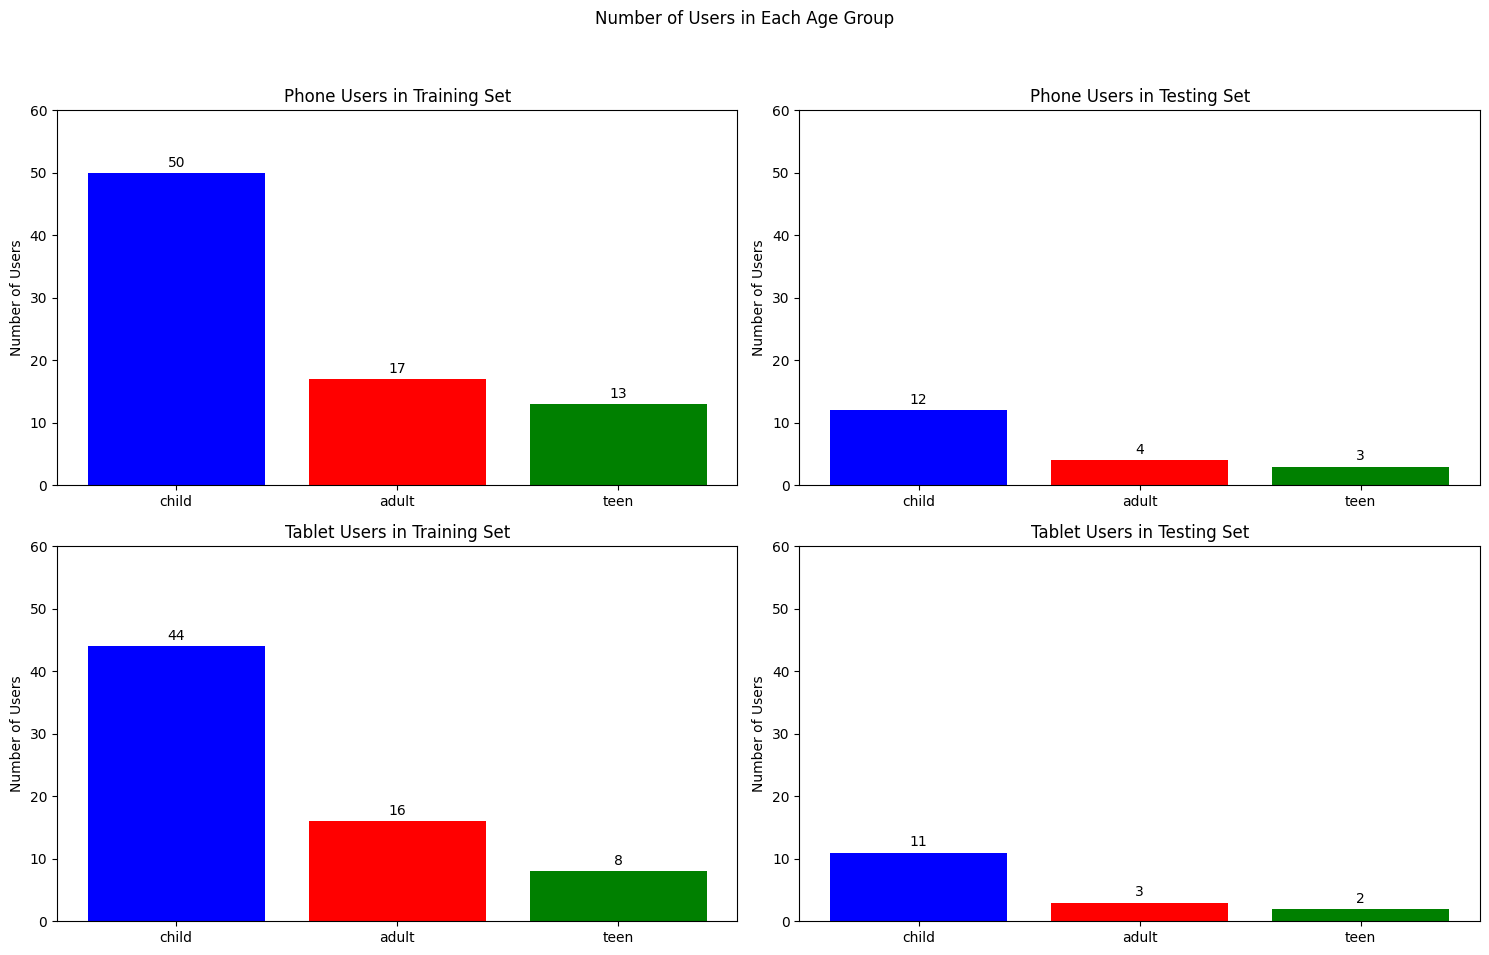

In [43]:
def show_num_users_in_each_age_group():
    # get user dataframe
    user_df = get_user_df()

    # get tablet and phone users in train and test sets
    phone_users_train, phone_users_test = get_users_train_and_test(
        get_phone_users())
    tablet_users_train, tablet_users_test = get_users_train_and_test(
        get_tablet_users())

    # Create a dictionary with the count of child, teen, and adult users
    num_phone_users_train = user_df[user_df['user_id'].isin(
        phone_users_train)]['age_group'].value_counts().to_dict()
    
    num_phone_users_test = user_df[user_df['user_id'].isin(
        phone_users_test)]['age_group'].value_counts().to_dict()

    num_tablet_users_train = user_df[user_df['user_id'].isin(
        tablet_users_train)]['age_group'].value_counts().to_dict()

    num_tablet_users_test = user_df[user_df['user_id'].isin(
        tablet_users_test)]['age_group'].value_counts().to_dict()

    # Define colors for each age group
    colors = {
        'child': 'blue',
        'teen': 'green',
        'adult': 'red'
    }

    # Create a bar chart for each set
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Number of Users in Each Age Group')

    # Function to add labels on top of bars
    def add_labels(ax, data):
        for i, (key, value) in enumerate(data.items()):
            ax.text(i, value + 1, str(value), ha='center')

    # Plot data for Phone Users in Training Set
    axes[0, 0].bar(num_phone_users_train.keys(), num_phone_users_train.values(
    ), color=[colors[key] for key in num_phone_users_train.keys()])
    axes[0, 0].set_title('Phone Users in Training Set')
    axes[0, 0].set_ylabel('Number of Users')
    axes[0, 0].set_ylim(0, 60)
    add_labels(axes[0, 0], num_phone_users_train)

    # Plot data for Phone Users in Testing Set
    axes[0, 1].bar(num_phone_users_test.keys(), num_phone_users_test.values(
    ), color=[colors[key] for key in num_phone_users_test.keys()])
    axes[0, 1].set_title('Phone Users in Testing Set')
    axes[0, 1].set_ylabel('Number of Users')
    axes[0, 1].set_ylim(0, 60)
    add_labels(axes[0, 1], num_phone_users_test)

    # Plot data for Tablet Users in Training Set
    axes[1, 0].bar(num_tablet_users_train.keys(), num_tablet_users_train.values(
    ), color=[colors[key] for key in num_tablet_users_train.keys()])
    axes[1, 0].set_title('Tablet Users in Training Set')
    axes[1, 0].set_ylabel('Number of Users')
    axes[1, 0].set_ylim(0, 60)
    add_labels(axes[1, 0], num_tablet_users_train)

    # Plot data for Tablet Users in Testing Set
    axes[1, 1].bar(num_tablet_users_test.keys(), num_tablet_users_test.values(
    ), color=[colors[key] for key in num_tablet_users_test.keys()])
    axes[1, 1].set_title('Tablet Users in Testing Set')
    axes[1, 1].set_ylabel('Number of Users')
    axes[1, 1].set_ylim(0, 60)
    add_labels(axes[1, 1], num_tablet_users_test)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# draw diagram
show_num_users_in_each_age_group()

# Single Gesture Classifiers

## Tap